In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data proces

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['DNN_v001.ipynb', 'don-t-over-fit-by-nn.ipynb', 'NN_v01.ipynb', 'tutorial']


In [5]:
# Libraries
# pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
from sklearn.feature_selection import RFECV



from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer.cuda import to_cpu

import optuna

In [6]:
train_url = 'https://raw.githubusercontent.com/lucascheng24/comp4432ML-Dont-over-fit-II/main/train.csv'
test_url = 'https://raw.githubusercontent.com/lucascheng24/comp4432ML-Dont-over-fit-II/main/test.csv'


train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
train.shape

(250, 302)

In [7]:
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


Text(0.5, 1.0, 'Distribution of stds of all columns')

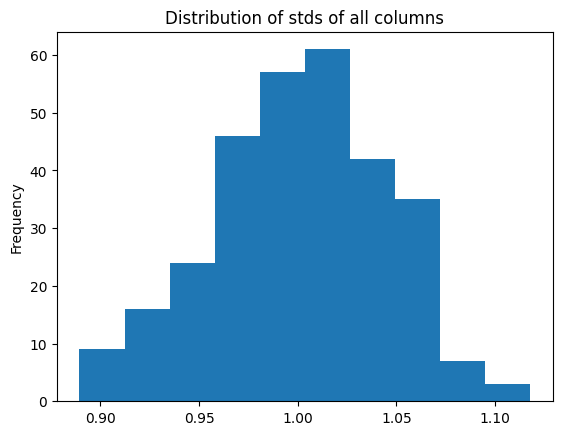

In [9]:
train[train.columns[2:]].std().plot(kind='hist')
plt.title('Distribution of stds of all columns')

Text(0.5, 1.0, 'Distribution of means of all columns')

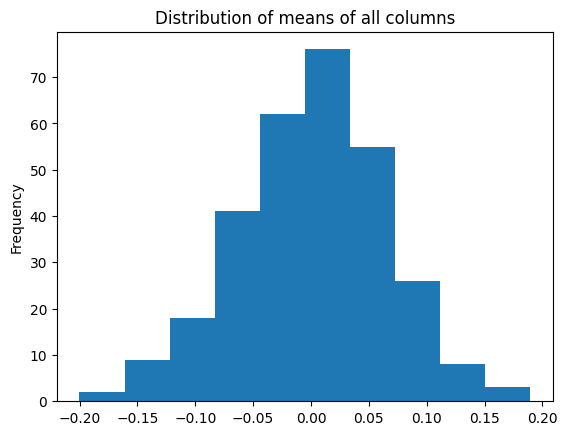

In [10]:
train[train.columns[2:]].mean().plot(kind='hist')
plt.title('Distribution of means of all columns')

In [11]:
# we have no missing values
train.isnull().any().any()

False

Distributions of first 28 columns


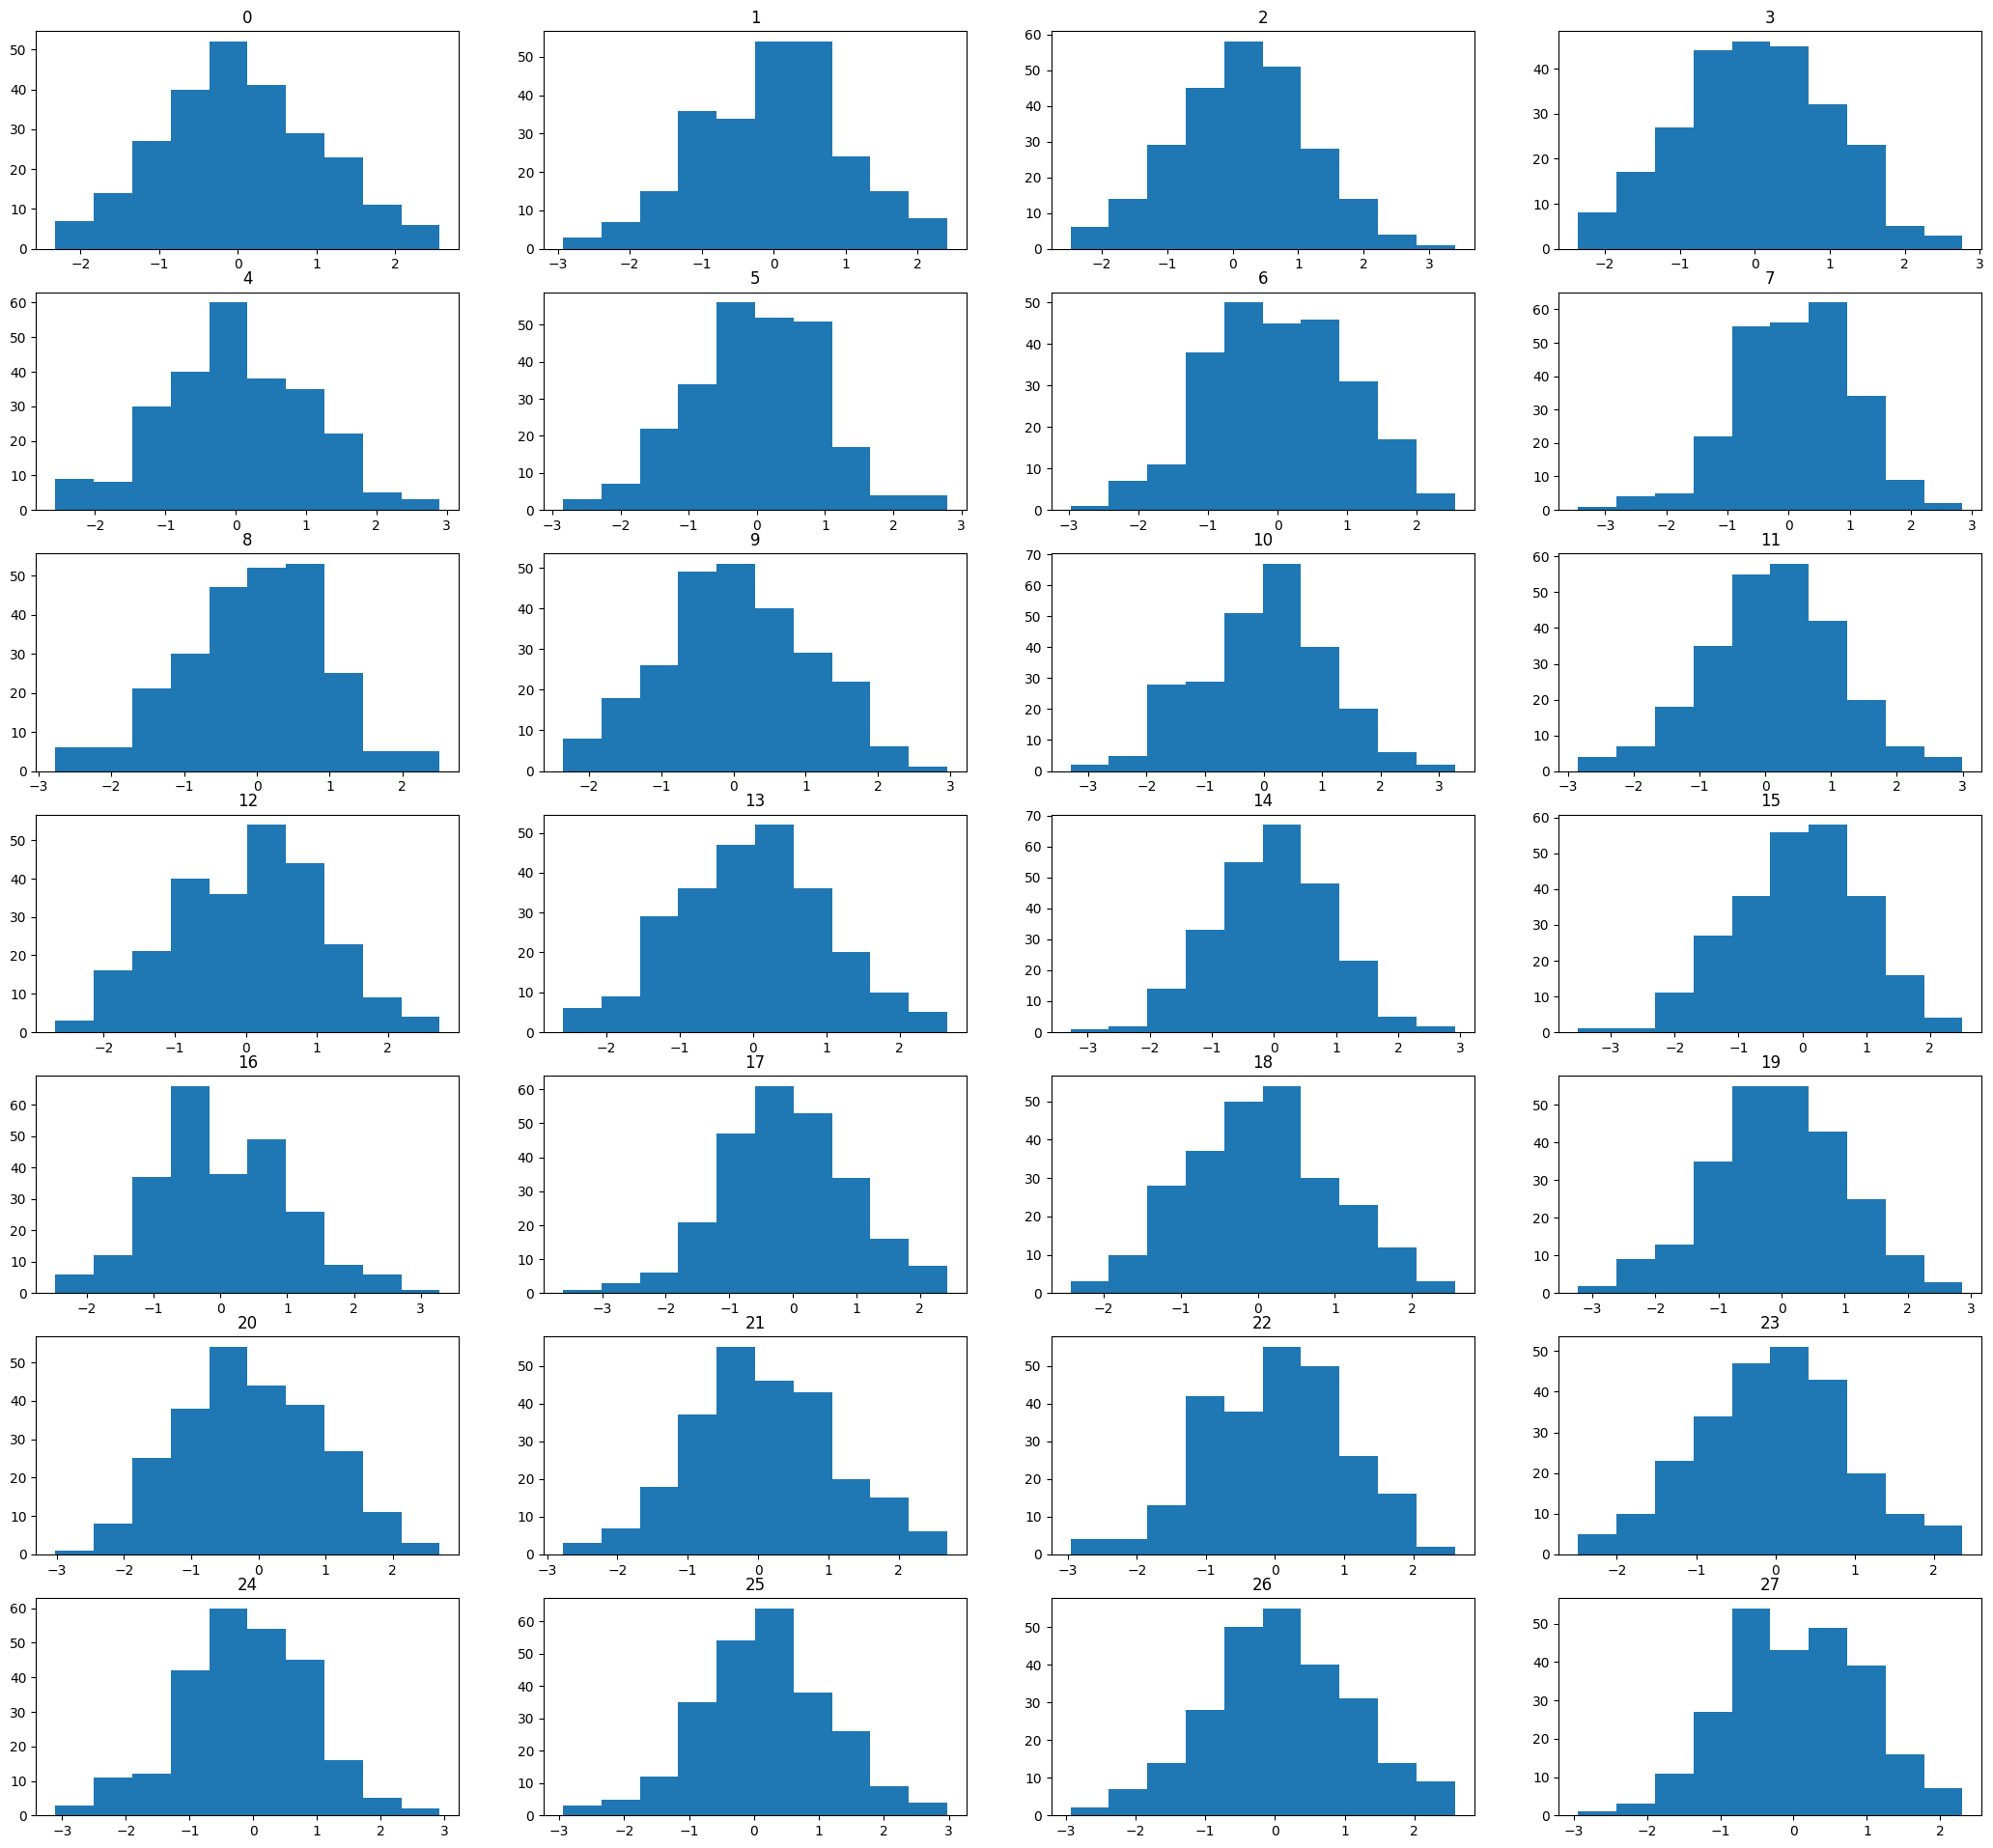

In [12]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [13]:
train['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [14]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


In [27]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# gpu = 0

In [28]:
def create_model(trial, mode = "trial", params = None):
    layers = []
    if mode == "trial":
        n_fc_layers = trial.suggest_int('n_fc_layers', 1, 3)
        for i in range(n_fc_layers):
            n_units = int(trial.suggest_loguniform('n_units_l{}'.format(i), 4, 128))
            layers.append(L.Linear(None, n_units))
            layers.append(F.relu)
        layers.append(L.Linear(None, 1))
    elif mode == "train":
        if params==None:
            assert("Not found param error!")
            return None
        n_fc_layers = params['n_fc_layers']
        for i in range(n_fc_layers):
            n_units = int(params['n_units_l{}'.format(i)])
            layers.append(L.Linear(None, n_units))
            layers.append(F.relu)
        layers.append(L.Linear(None, 1))
    return chainer.Sequential(*layers)

In [29]:
def create_optimizer(trial, model, params=None):
    # 最適化関数の選択
    if trial is not None:
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'MomentumSGD'])
        if optimizer_name == 'Adam':
            adam_alpha = trial.suggest_loguniform('adam_alpha', 1e-5, 1e-1)
            optimizer = chainer.optimizers.Adam(alpha=adam_alpha)
        else:
            momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
            optimizer = chainer.optimizers.MomentumSGD(lr=momentum_sgd_lr)

        weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    else:
        if params == None:
            assert("Not found params error!")
        optimizer_name = params["optimizer"]
        if optimizer_name == 'Adam':
            adam_alpha = params["adam_alpha"]
            optimizer = chainer.optimizers.Adam(alpha=adam_alpha)
        else:
            momentum_sgd_lr = params["momentum_sgd_lr"]
            optimizer = chainer.optimizers.MomentumSGD(lr=momentum_sgd_lr)
        weight_decay = params['weight_decay']
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(weight_decay))
    return optimizer

In [30]:
import chainer
from chainer import datasets
class Dataset(chainer.dataset.DatasetMixin):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def get_example(self, i):
        return self.x[i], self.y[i]
    
    

In [31]:
from chainer import report 
class MyRegressor(chainer.Chain):

    def __init__(self, predictor):
        super(MyRegressor, self).__init__(predictor=predictor)

    def __call__(self, x, y):
        pred = self.predictor(x)
        loss = F.mean_squared_error(pred, y)

        report({'loss': loss}, self)
        return loss
    
def objective(trial, X_train, X_valid, y_train, y_valid):
    # モデルのインスタンス化
    model = MyRegressor(create_model(trial))
    optimizer = create_optimizer(trial, model) # モデルとoptimizerを紐付ける

    # モデルをGPUに移動
    # gpu_id = 0
    # model.to_gpu(gpu_id)
    max_epoch = 100
    now_epoch = 0
    X_train_, X_valid_ = model.xp.asarray(X_train), model.xp.asarray(X_valid)
    y_train_, y_valid_ = model.xp.asarray(y_train), model.xp.asarray(y_valid)
    X_test_ = model.xp.asarray(X_test)
    train = Dataset(X_train_, y_train_)
    valid = Dataset(X_valid_, y_valid_)
    train_iter = chainer.iterators.SerialIterator(train, train.__len__())
    valid_iter = chainer.iterators.SerialIterator(valid, test.__len__(), repeat=False, shuffle=False)
    # updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)
    updater = chainer.training.StandardUpdater(train_iter, optimizer)
    
    trainer = chainer.training.Trainer(updater, (max_epoch, 'epoch'))
    trainer.extend(chainer.training.extensions.Evaluator(valid_iter, model))
    # trainer.extend(chainer.training.extensions.Evaluator(valid_iter, model, device=gpu_id))
    log_report_extension = chainer.training.extensions.LogReport(log_name=None)
#     trainer.extend(chainer.training.extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss','elapsed_time']))
    trainer.extend(log_report_extension)
    # 学習の実行
    trainer.run()

    # 学習結果の保存
    log_last = log_report_extension.log[-1]
    for key, value in log_last.items():
        trial.set_user_attr(key, value)
        
    with chainer.using_config('train', False), \
                chainer.using_config('enable_backprop', False):
        y_pred_valid = model.predictor(X_valid_)

        score = roc_auc_score(to_cpu(y_valid_), to_cpu(y_pred_valid.data))
#         print('test_score:{:.04f}'.format(score))
    
    # 最終的なバリデーションの値を返す
    return 1.0 - score

In [32]:
from functools import partial

# def train_model(X, X_test, y, folds=folds, gpu_id=0):

def train_model(X, X_test, y, folds=folds):
    prediction = np.zeros(len(X_test))[:, None]
    scores = []
    X_test = X_test.astype(np.float32)
    study = None
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index].astype(np.float32), X[valid_index].astype(np.float32)
        y_train, y_valid = y[train_index].astype(np.float32)[:, None], y[valid_index].astype(np.float32)[:, None]
        if fold_n == 0:
            study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
            study.optimize(partial(objective, X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid), n_trials=100)
            print('Number of finished trials: ', len(study.trials))
            trial = study.best_trial
            print('Best trial: ', )
            print('Params: ')
            param_n=[]
            param_v=[]
            for key, value in trial.params.items():
                print('{}:{}'.format(key, value))
                param_n.append(key)
                param_v.append(value)

            print('User attrs: ')
            attrs_n=[]
            attrs_v=[]
            for key, value in trial.user_attrs.items():
                print('{}:{}'.format(key, value))
                attrs_n.append(key)
                attrs_v.append(value)
        else:
            trial = study.best_trial
            model = MyRegressor(create_model(trial=None, mode="train", params=trial.params))
            optimizer = create_optimizer(trial=None, model=model, params=trial.params)
            # gpu_id = 0
            # model.to_gpu(gpu_id)
            max_epoch = 100
            now_epoch = 0
            X_train, X_valid = model.xp.asarray(X_train), model.xp.asarray(X_valid)
            y_train, y_valid = model.xp.asarray(y_train), model.xp.asarray(y_valid)
            X_test = model.xp.asarray(X_test)
            train = Dataset(X_train, y_train)
            valid = Dataset(X_valid, y_valid)
            train_iter = chainer.iterators.SerialIterator(train, train.__len__())
            valid_iter = chainer.iterators.SerialIterator(valid, test.__len__(), repeat=False, shuffle=False)
            updater = chainer.training.StandardUpdater(train_iter, optimizer)
            # updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)

            trainer = chainer.training.Trainer(updater, (max_epoch, 'epoch'))
            trainer.extend(chainer.training.extensions.Evaluator(valid_iter, model))
            # trainer.extend(chainer.training.extensions.Evaluator(valid_iter, model, device=gpu_id))
            log_report_extension = chainer.training.extensions.LogReport(log_name=None)
#             trainer.extend(chainer.training.extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss','elapsed_time']))
            trainer.extend(log_report_extension)
            # 学習の実行
            trainer.run()
            with chainer.using_config('train', False), \
                        chainer.using_config('enable_backprop', False):
                y_pred_valid = model.predictor(X_valid)

                score = roc_auc_score(to_cpu(y_valid), to_cpu(y_pred_valid.data))
                scores.append(score)
                print('test_score:{:.04f}'.format(score))
            y_pred = model.predictor(X_test)
            prediction += to_cpu(y_pred.data)
    prediction /= (n_fold - 1)
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    
    return prediction, scores

In [33]:
prediction, scores = train_model(X_train, X_test, y_train, folds=repeated_folds)

[I 2023-03-22 19:08:09,455] A new study created in memory with name: no-name-0e9f8748-24e4-41a8-ade4-689b931f610d
[I 2023-03-22 19:08:09,891] Trial 0 finished with value: 0.42500000000000004 and parameters: {'n_fc_layers': 1, 'n_units_l0': 57.589452608388214, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.00012259678987355658, 'weight_decay': 6.398851807197404e-09}. Best is trial 0 with value: 0.42500000000000004.
[I 2023-03-22 19:08:10,336] Trial 1 finished with value: 0.29999999999999993 and parameters: {'n_fc_layers': 2, 'n_units_l0': 16.5500570681575, 'n_units_l1': 4.04399700066777, 'optimizer': 'Adam', 'adam_alpha': 2.1900039433993502e-05, 'weight_decay': 2.8948375375344224e-09}. Best is trial 1 with value: 0.29999999999999993.
[I 2023-03-22 19:08:11,033] Trial 2 finished with value: 0.15000000000000002 and parameters: {'n_fc_layers': 2, 'n_units_l0': 25.062774684284282, 'n_units_l1': 62.461188023985414, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.009352751790474317, 'weigh

Number of finished trials:  100
Best trial: 
Params: 
n_fc_layers:2
n_units_l0:22.846003872773938
n_units_l1:44.020866192899184
optimizer:MomentumSGD
momentum_sgd_lr:0.001626015186186274
weight_decay:9.900969159975103e-10
User attrs: 
main/loss:0.060460299253463745
validation/main/loss:0.11237084865570068
epoch:100
iteration:100
elapsed_time:0.4612833999999566
test_score:0.4500
test_score:0.6000
test_score:0.6250
test_score:0.6000
test_score:0.7000
test_score:0.6250
test_score:0.4250
test_score:0.7250
test_score:0.6000
test_score:0.4062
test_score:0.3750
test_score:0.5625
test_score:0.6875
test_score:0.7500
test_score:0.4688
test_score:0.5312
test_score:0.7500
test_score:0.6250
test_score:0.4062
test_score:0.6500
test_score:0.5500
test_score:0.4500
test_score:0.4000
test_score:0.5250
test_score:0.3750
test_score:0.3750
test_score:0.6250
test_score:0.5250
test_score:0.4250
test_score:0.9375
test_score:0.5312
test_score:0.5312
test_score:0.4688
test_score:0.3125
test_score:0.4688
test_sc

In [ ]:
# # v9 0.849, v10(RobustScaler) 0.846
# submission = pd.read_csv('../input/sample_submission.csv')
# submission['target'] = prediction_lasso_repeated
# submission.to_csv('lasso_repeat_cv.csv', index=False)

# submission.head()

In [ ]:
# submission = pd.read_csv('../input/sample_submission.csv')
# submission['target'] = prediction
# submission.to_csv('MLP.csv', index=False)

# submission.head()

In [ ]:
import csv


filePath = '../result_folder/MLP_v1.csv'


with open(filePath, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "target"])
    for i in range(250, 20000):
        writer.writerow([i, prediction[i-250]])
    file.close()